In [1]:
! pip install -r ../requirements.txt

  Using cached transformers-4.25.1-py3-none-any.whl (5.8 MB)
  Using cached huggingface_hub-0.11.1-py3-none-any.whl (182 kB)
     |████████████████████████████████| 3.8 MB 2.7 MB/s eta 0:00:01
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
     |████████████████████████████████| 42 kB 2.5 MB/s eta 0:00:01
ERROR: bokeh 2.4.2 has requirement pillow>=7.1.0, but you'll have pillow 6.1.0 which is incompatible.
ERROR: transformers 4.25.1 has requirement numpy>=1.17, but you'll have numpy 1.16.4 which is incompatible.
  Attempting uninstall: packaging
    Found existing installation: packaging 19.2
    Uninstalling packaging-19.2:
      Successfully uninstalled packaging-19.2
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.26.0
    Uninstalling tqdm-4.26.0:
      Successfully uninstalled tqdm-4.26.0
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import torch
import copy
import math
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.expanduser("~/repos/NeurOps/pytorch"))
from neurops import *

from growprune import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
hidden = [32]
regression = False

base_data = ToyData(64, 32, 5000, regression=regression)
train_loader, val_loader, test_loader = split_dataset(base_data, val_size = 0.1, test_size = 0.1, batch_size = 128)



model = ModSequential(
        ModLinear(64, hidden[0], masked=True, prebatchnorm=True, learnable_mask=True),
        #ModLinear(hidden[0], hidden[1], masked=True, prebatchnorm=True, learnable_mask=True),
        ModLinear(hidden[0], 1 if regression else 2, masked=True, prebatchnorm=True),
        track_activations=10,
        track_auxiliary_gradients=True
    ).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss() if regression else torch.nn.CrossEntropyLoss()

print("This model has {} effective parameters.".format(model.parameter_count(masked = True)))
#print("The conversion factor of this model is {} after layer {}.".format(model.conversion_factor, model.conversion_layer))

This model has 2178 effective parameters.


In [15]:
pre_losses, pre_accs, pre_acts = train(model, train_loader, optimizer, criterion, epochs=50, val_loader=val_loader, device=device, regression=regression, verbose=False, val_verbose=False, val_acts=True)
pre_vars = torch.cat([activation_variance(acts).unsqueeze(0) for acts in pre_acts["0"]], dim=0)
pre_svd_scores = torch.cat([svd_score(acts).unsqueeze(0) for acts in pre_acts["0"]], dim=0)
pre_orthog_gap = [orthogonality_gap(acts) for acts in pre_acts["0"]]

Training 32 epochs per shift, shifting window by 32 indices 2 times
tensor(0.0003)
tensor(0.0003)


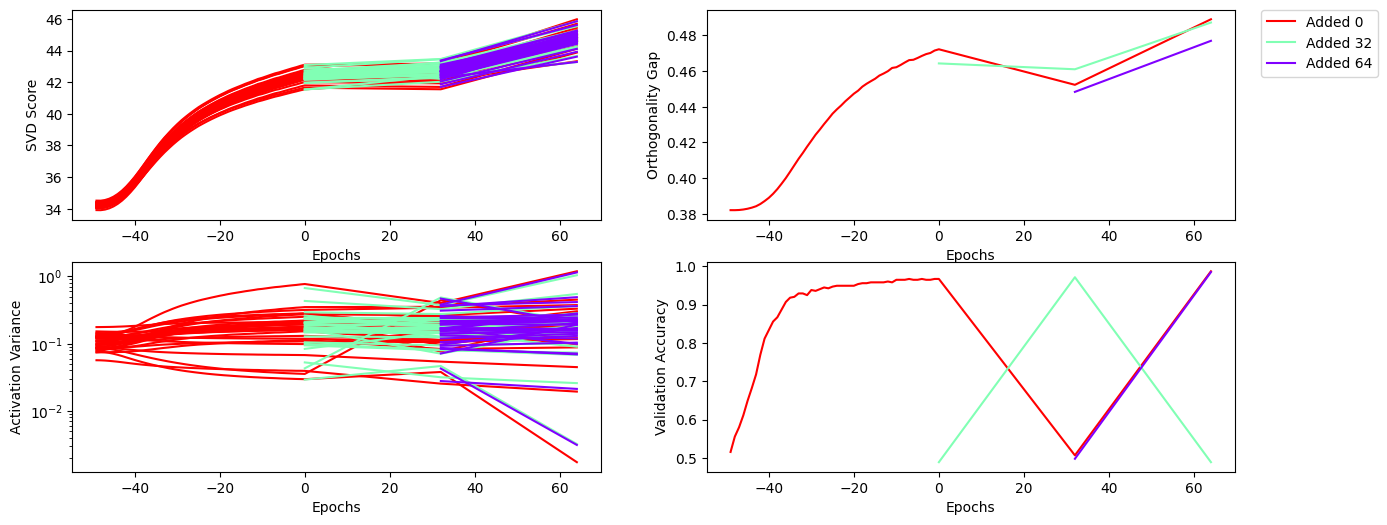

Training 16 epochs per shift, shifting window by 16 indices 4 times
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)


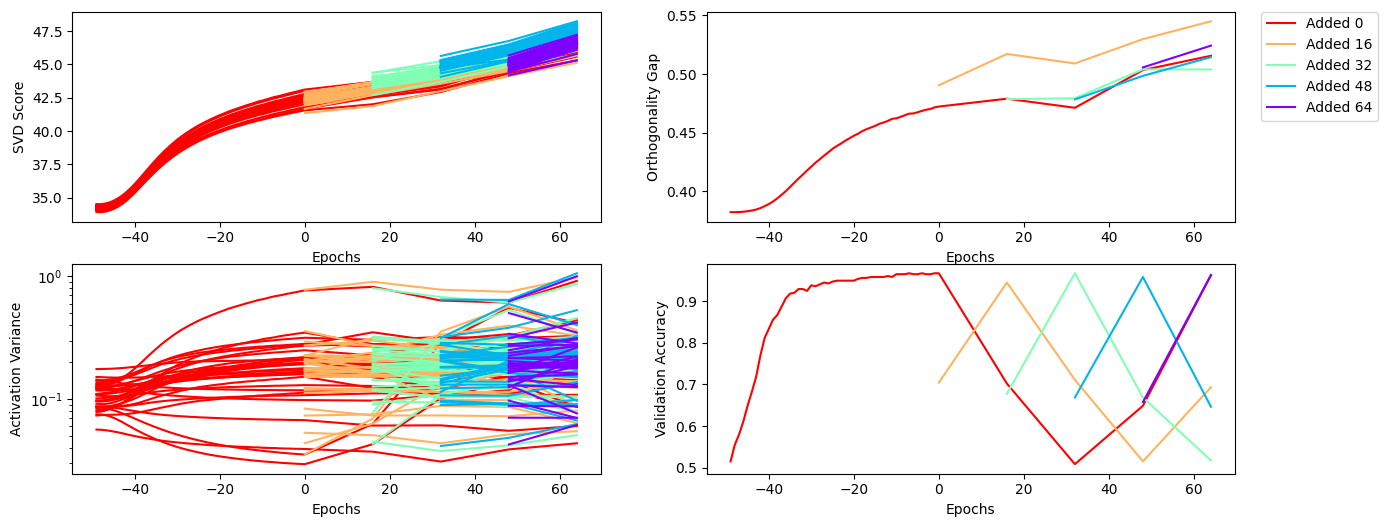

Training 8 epochs per shift, shifting window by 8 indices 8 times
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)


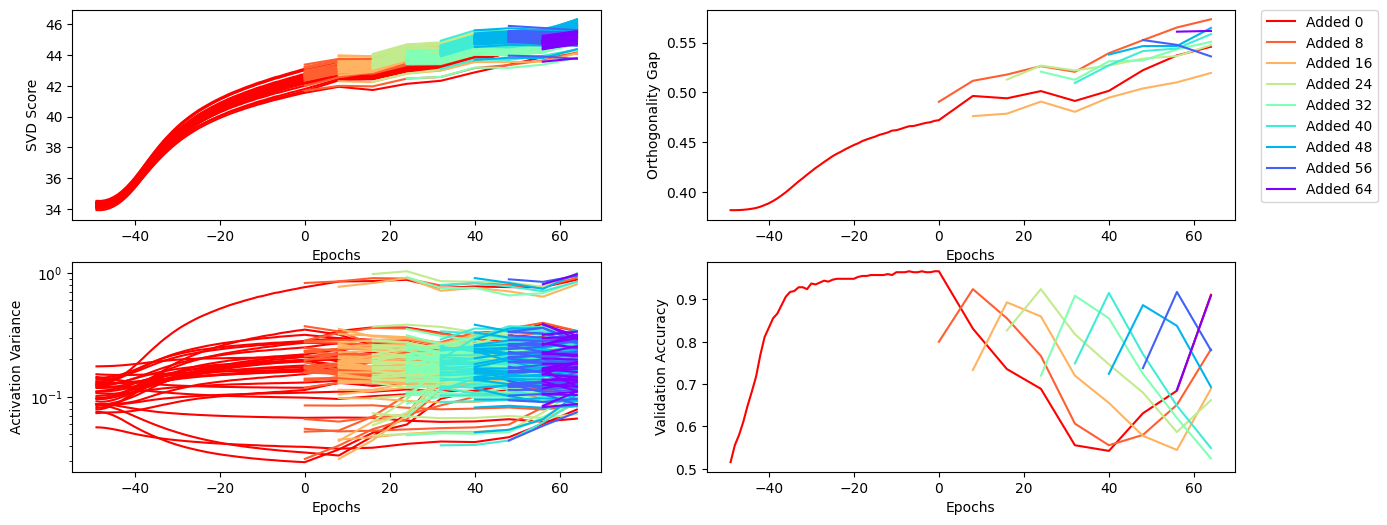

Training 4 epochs per shift, shifting window by 4 indices 16 times
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)
tensor(0.0003)


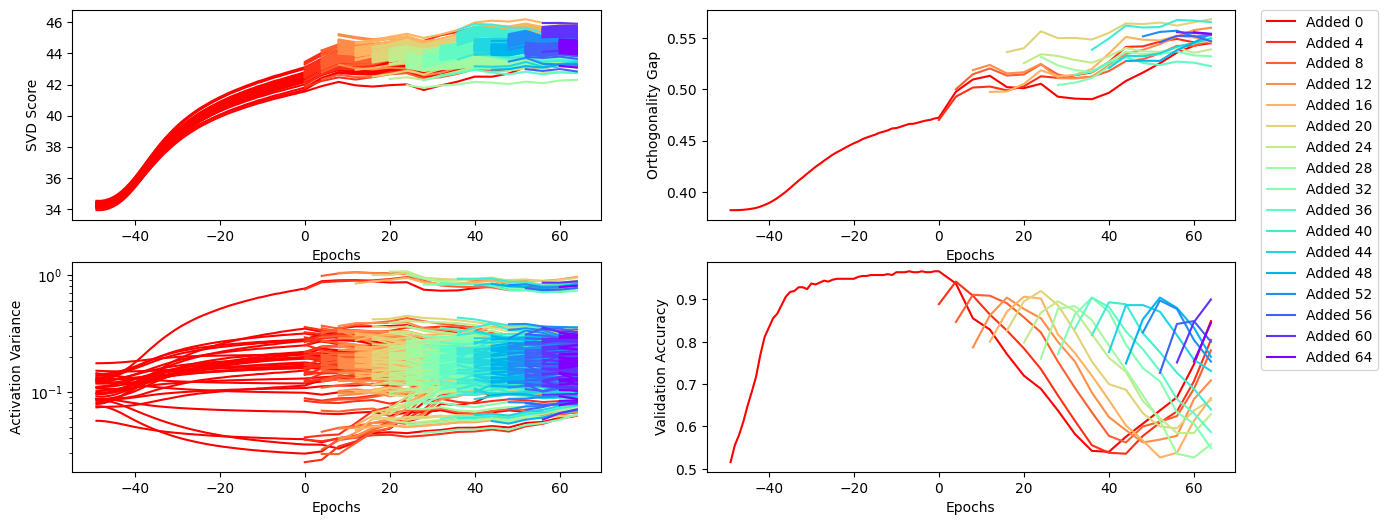

In [19]:
cmap = plt.get_cmap('rainbow')

for power in range(int(math.log(base_data.input_dim, 2))-2):
    mod = copy.deepcopy(model)
    mod_optimizer = torch.optim.SGD(mod.parameters(), lr=0.01)
    mod_optimizer.load_state_dict(optimizer.state_dict())

    loss, acc = test(mod, val_loader, criterion, device=device, regression=regression, verbose=False)
    accs = [list(pre_accs)]
    #svd_scores = [svd_score(mod.activations["0"]).unsqueeze(0)]
    svd_scores = [pre_svd_scores]
    vars = [pre_vars]
    #orthog_gaps = [[orthogonality_gap(mod.activations["0"])]]
    orthog_gaps = [list(pre_orthog_gap)]

    timestamp = list(range(-50, 1))

    shift = 2**(int(math.log(base_data.input_dim, 2))-power-1)
    datasets = [val_loader]
    
    print("Training {} epochs per shift, shifting window by {} indices {} times".format(64//int(base_data.input_dim/shift), shift, int(base_data.input_dim/shift)))
    for step in range(int(base_data.input_dim/shift)):
        modded_data = copy.deepcopy(base_data)
        #modded_data.shift_distribution(multiplier=(-1)**step, recompute_y=False)
        #modded_data.shift_distribution(adder=((step+1)*shift)/32, recompute_y=False)
        modded_data.shift_window((step+1)*shift)
        print(modded_data.X.mean())
        modded_train_loader, modded_val_loader, modded_test_loader = split_dataset(modded_data, val_size = 0.1, test_size = 0.1, batch_size = 128)
        datasets.append(modded_val_loader)
        loss, acc = test(mod, modded_val_loader, criterion, device=device, regression=regression, verbose=False)
        accs.append([acc])
        svd_scores.append(svd_score(mod.activations["0"]).unsqueeze(0))
        vars.append(activation_variance(mod.activations["0"]).unsqueeze(0))
        orthog_gaps.append([orthogonality_gap(mod.activations["0"])])
        loss_, acc_, acts_ = train(mod, modded_train_loader, mod_optimizer, criterion, epochs=64//int(base_data.input_dim/shift), val_loader=modded_val_loader, device=device, regression=regression, verbose=False, val_verbose=False, val_acts=True)
        timestamp.append(timestamp[-1]+64//int(base_data.input_dim/shift))
        for i, vl in enumerate(datasets):
            loss, acc = test(mod, vl, criterion, device=device, regression=regression, verbose=False)
            accs[i].append(acc)
            svd_scores[i] = torch.cat((svd_scores[i], svd_score(mod.activations["0"]).unsqueeze(0)), dim=0)
            vars[i] = torch.cat((vars[i], activation_variance(mod.activations["0"]).unsqueeze(0)), dim=0)
            orthog_gaps[i].append(orthogonality_gap(mod.activations["0"]))

    #plot the svd scores
    colors = [cmap(i) for i in np.linspace(1, 0, len(svd_scores))]
    fig, axs = plt.subplots(2,2, figsize=(15,6))
    for i, scores in enumerate(svd_scores):
        for neuron in range(scores.shape[1]):
            axs[0,0].plot(timestamp[-len(scores[:,neuron]):], scores[:,neuron], color=colors[i], label="Window {}".format(int(i*(64//(len(svd_scores)-1)))) if neuron == 0 else None)
    axs[0,0].set_xlabel("Epochs")
    axs[0,0].set_ylabel("SVD Score")
    for i, gaps in enumerate(orthog_gaps):
        axs[0,1].plot(timestamp[-len(gaps):], gaps, color=colors[i], label="Added {}".format(int(i*(64//(len(svd_scores)-1)))))
        axs[1,0].plot(timestamp[-len(vars[i]):], vars[i], color=colors[i], label="Added {}".format(int(i*(64//(len(svd_scores)-1)))))
        axs[1,1].plot(timestamp[-len(accs[i]):], accs[i], color=colors[i], label="Added {}".format(int(i*(64//(len(svd_scores)-1)))))
    axs[0,1].set_xlabel("Epochs")
    axs[0,1].set_ylabel("Orthogonality Gap")
    axs[1,0].set_xlabel("Epochs")
    axs[1,0].set_ylabel("Activation Variance")
    #make y axis log scale
    axs[1,0].set_yscale('log')
    axs[1,1].set_xlabel("Epochs")
    axs[1,1].set_ylabel("Validation Accuracy")
    axs[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

    #print(datasets[0].dataset.y == datasets[-1].dataset.y)

-1: 149.421 0.1	0: 49.525 0.4	1: 9.108 0.9	
tensor([0.1658, 0.1058, 0.1535, 0.0828, 0.0946, 0.1927, 0.1510, 0.1303, 0.1916,
        0.1472, 0.1323, 0.1504, 0.4767, 0.6599, 0.0245, 0.0244, 0.1056, 0.0506,
        0.1632, 0.4092, 0.0488, 0.2861, 0.1451, 0.1183, 0.1679, 0.2682, 0.1727,
        0.1584, 0.2954, 0.1310, 0.0359, 0.1427])
Training 32 epochs per shift, shifting window by 32 indices 2 times
52 53
3 53
2 53


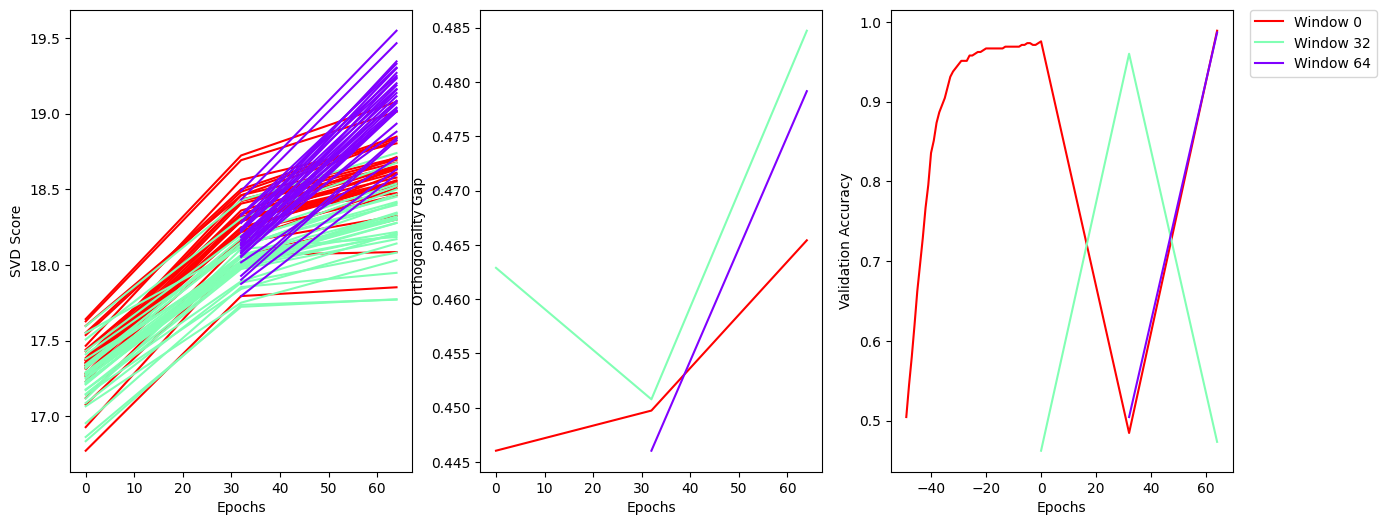

Training 16 epochs per shift, shifting window by 16 indices 4 times
54 55
5 55
4 55
3 55
2 55


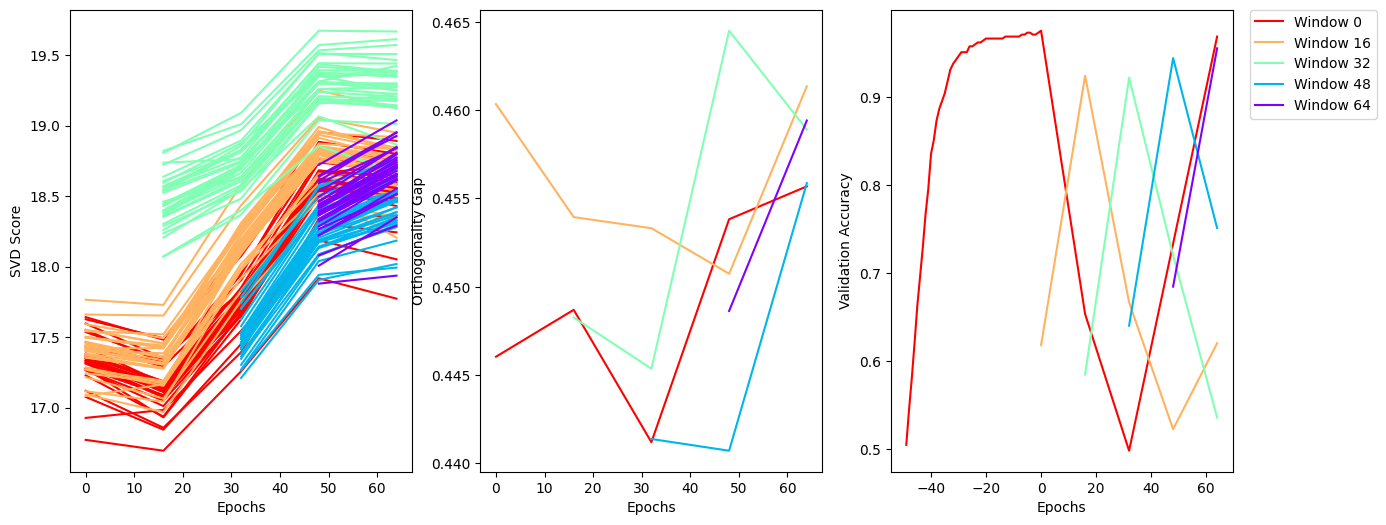

Training 8 epochs per shift, shifting window by 8 indices 8 times
58 59
9 59
8 59
7 59
6 59
5 59
4 59
3 59
2 59


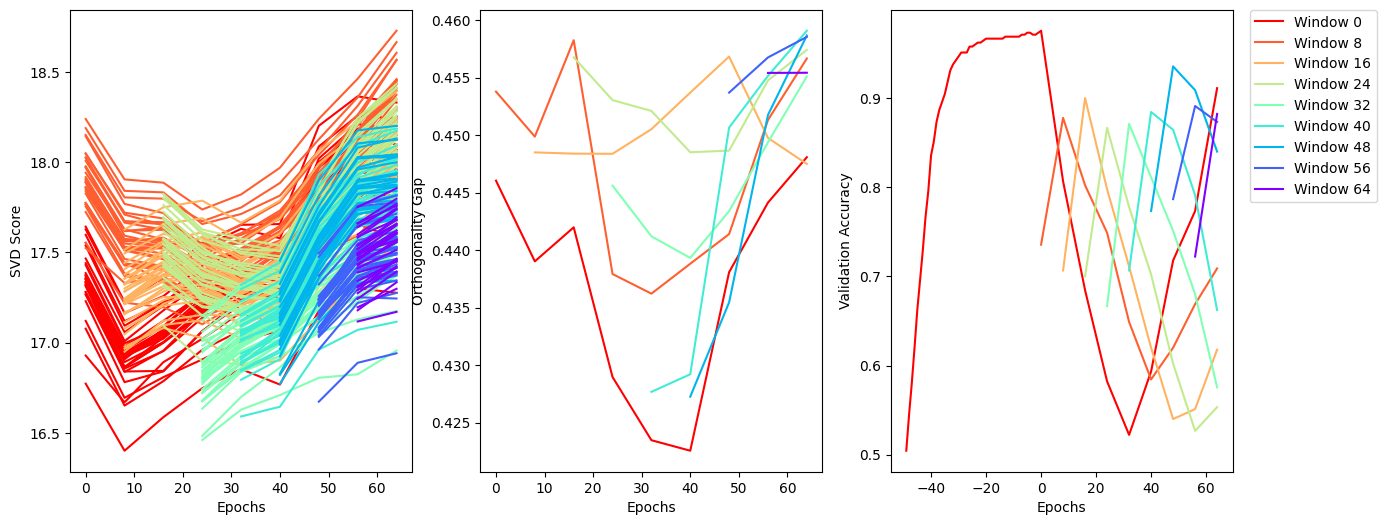

Training 4 epochs per shift, shifting window by 4 indices 16 times
66 67
17 67
16 67
15 67
14 67
13 67
12 67
11 67
10 67
9 67
8 67
7 67
6 67
5 67
4 67
3 67
2 67


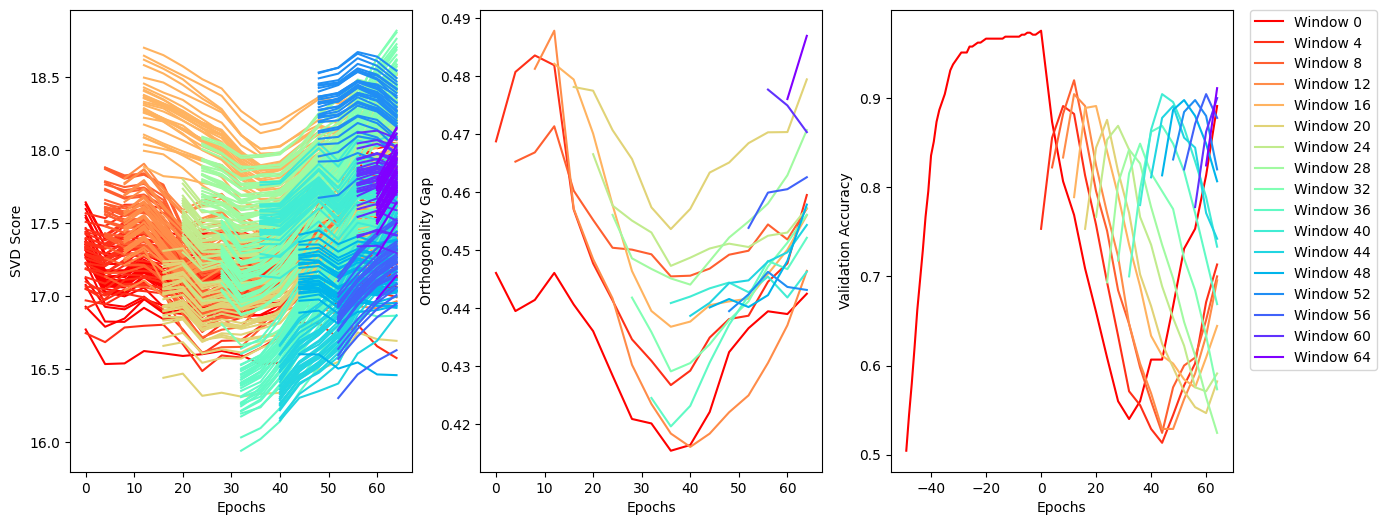

In [16]:
for key, value in model.activations.items():
    print("{}: {:.3f} {}".format(key, effective_rank(value, partial=True).item(), round(orthogonality_gap(value).item(), 1)), end="\t")
print()
print(activation_variance(model.activations["0"]))

cmap = plt.get_cmap('rainbow')

for power in range(int(math.log(base_data.input_dim, 2))-2):
    mod = copy.deepcopy(model)
    mod_optimizer = torch.optim.SGD(mod.parameters(), lr=0.01)
    mod_optimizer.load_state_dict(optimizer.state_dict())

    loss, acc = test(mod, val_loader, criterion, device=device, regression=regression, verbose=False)
    accs = [list(pre_accs)]
    svd_scores = [svd_score(mod.activations["0"]).unsqueeze(0)]
    orthog_gaps = [[orthogonality_gap(mod.activations["0"])]]

    timestamp = list(range(-50, 1))

    shift = 2**(int(math.log(base_data.input_dim, 2))-power-1)
    datasets = [val_loader]
    
    print("Training {} epochs per shift, shifting window by {} indices {} times".format(64//int(base_data.input_dim/shift), shift, int(base_data.input_dim/shift)))
    for step in range(int(base_data.input_dim/shift)):
        modded_data = copy.deepcopy(base_data)
        #modded_data.shift_distribution(adder=((step+1)*shift)/32)
        modded_data.shift_window((step+1)*shift)
        modded_train_loader, modded_val_loader, modded_test_loader = split_dataset(modded_data, val_size = 0.1, test_size = 0.1, batch_size = 128)
        datasets.append(modded_val_loader)
        loss, acc = test(mod, modded_val_loader, criterion, device=device, regression=regression, verbose=False)
        accs.append([acc])
        svd_scores.append(svd_score(mod.activations["0"]).unsqueeze(0))
        orthog_gaps.append([orthogonality_gap(mod.activations["0"])])
        train(mod, modded_train_loader, mod_optimizer, criterion, epochs=64//int(base_data.input_dim/shift), val_loader=modded_val_loader, device=device, regression=regression, verbose=False, val_verbose=False)
        timestamp.append(timestamp[-1]+64//int(base_data.input_dim/shift))
        for i, vl in enumerate(datasets):
            loss, acc = test(mod, vl, criterion, device=device, regression=regression, verbose=False)
            accs[i].append(acc)
            svd_scores[i] = torch.cat((svd_scores[i], svd_score(mod.activations["0"]).unsqueeze(0)), dim=0)
            orthog_gaps[i].append(orthogonality_gap(mod.activations["0"]))

    #plot the svd scores
    colors = [cmap(i) for i in np.linspace(1, 0, len(svd_scores))]
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,6))
    for i, scores in enumerate(svd_scores):
        for neuron in range(scores.shape[1]):
            ax1.plot(timestamp[-len(scores[:,neuron]):], scores[:,neuron], color=colors[i], label="Window {}".format(int(i*(64//(len(svd_scores)-1)))) if neuron == 0 else None)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("SVD Score")
    for i, gaps in enumerate(orthog_gaps):
        ax2.plot(timestamp[-len(gaps):], gaps, color=colors[i], label="Window {}".format(int(i*(64//(len(svd_scores)-1)))))
        print(len(accs[i]), len(timestamp))
        ax3.plot(timestamp[-len(accs[i]):], accs[i], color=colors[i], label="Window {}".format(int(i*(64//(len(svd_scores)-1)))))
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Orthogonality Gap")
    ax3.set_xlabel("Epochs")
    ax3.set_ylabel("Validation Accuracy")
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()

    #print(datasets[0].dataset.y == datasets[-1].dataset.y)

['_DataLoader__initialized', '_DataLoader__multiprocessing_context', '_IterableDataset_len_called', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_auto_collation', '_dataset_kind', '_get_iterator', '_index_sampler', '_is_protocol', '_iterator', 'batch_sampler', 'batch_size', 'check_worker_number_rationality', 'collate_fn', 'dataset', 'drop_last', 'generator', 'multiprocessing_context', 'num_workers', 'persistent_workers', 'pin_memory', 'pin_memory_device', 'prefetch_factor', 'sampler', 'timeout', 'worker_init_fn']


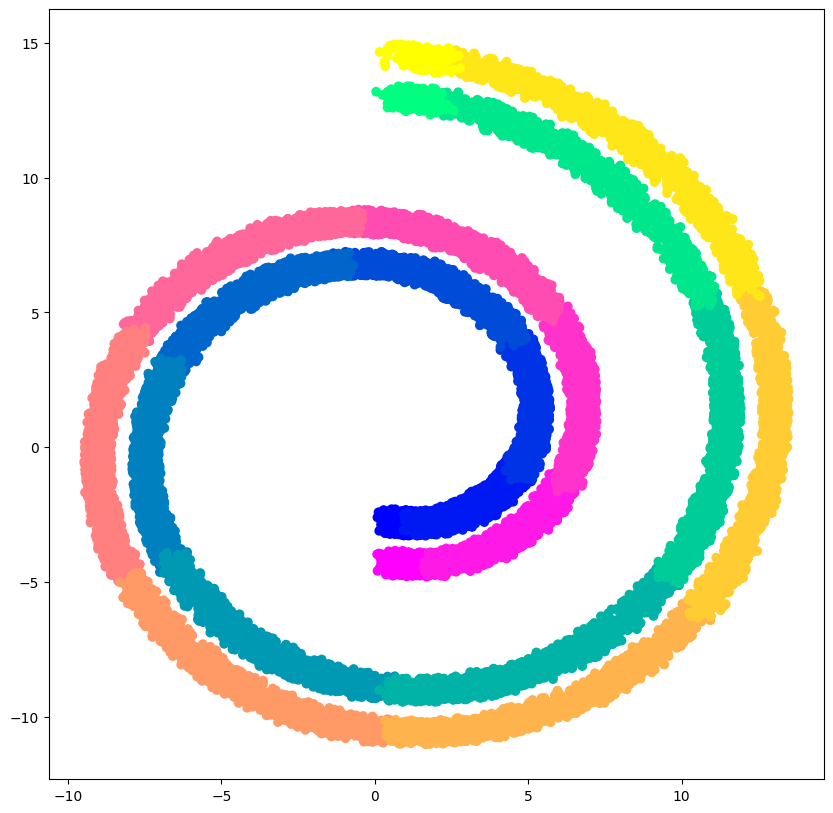

In [84]:

n_samples = 10000

t = np.sort(1.5 * np.pi * (1 + 2*np.random.uniform(size=n_samples)))
t2 = np.sort(1.5 * np.pi * (2/3 + 2*np.random.uniform(size=n_samples)))

x = t * np.cos(t)
y = t * np.sin(t)

x2 = t2 * np.cos(t2+np.pi/2)
y2 = t2 * np.sin(t2+np.pi/2)

X = np.vstack((x, y)).T
noise = 0.9 * np.random.random(size=(n_samples, 2))
X += noise
t = np.squeeze(t)

X2 = np.vstack((x2, y2)).T
noise2 = 0.9 * np.random.random(size=(n_samples, 2))
X2 += noise2
t2 = np.squeeze(t2)

#plot the data
fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(X[:,0], X[:,1], X[:,2], c=t, cmap=plt.cm.Spectral)
ax = fig.add_subplot(111)
ax.scatter(X[:,0], X[:,1], c=t.astype(int), cmap="spring")
ax.scatter(X2[:,0], X2[:,1], c=t.astype(int), cmap="winter")
plt.show()